In [1]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, NLocal, PauliTwoDesign
# from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD # chemistry simulation ansatzes, for example the UCCSD ansatz prepares a state where tuning the parameters turns excitations on and off
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
import numpy as np 
from numpy import sqrt, pi, linalg
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.result import marginal_counts
from IPython.display import display, clear_output
from qiskit import Aer, transpile, assemble
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_bloch_vector, plot_state_qsphere
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, PauliOp
from qiskit_optimization import QuadraticProgram
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ, execute
IBMQ.load_account()
provider = IBMQ.get_provider(group='open', project='main')

In [2]:
# Prepare State Circuit (n Qubit)-cu3 only
def PrepareState(parameter,q = 2):
    qg = QuantumRegister(q,'q')
    qc = QuantumCircuit(qg)
    
    qc.u3(parameter[0],parameter[1],-parameter[1],q-1)
    qc.barrier(range(q))
    theta = 2
    
    for i in range(q):
        for j in range(q-i-1):
            qc.cu3(parameter[theta],parameter[theta+1],-parameter[theta+1],i+j+1,i)
            qc.x(i+j+1)
            qc.cu3(parameter[theta+2],parameter[theta+3],-parameter[theta+3],i+j+1,i)
            qc.x(i+j+1)
            theta +=4
            qc.barrier(range(q))
    return qc

In [3]:
# Prepare general State Circuit (n Qubit)-Multicontrol qubit
def PrepareState_Gen(parameter,q = 2):
    # Multi control U3 gate
    def MCUGate(p1,p2,ctrlqubit):
        ctrl = QuantumCircuit(1, name='U3')
        # U3 decompose
        ctrl.rz(p2,0)
        ctrl.rx(-np.pi/2,0)
        ctrl.rz(p1,0)
        ctrl.rx(np.pi/2,0)
        ctrl.rz(-p2,0)
        # U3 decompose
        ctrl = ctrl.to_gate().control(ctrlqubit)
        return ctrl
    # State's bit string converter
    def Bitstring(inter,leng):
        result = []
        while inter >= 2:
            d = inter % 2
            inter = inter//2
            result.append(d)
        result.append(inter)
        for i in range(leng-len(result)):
            result.append(0)
        return result

    qg = QuantumRegister(q,'q')
    qc = QuantumCircuit(qg)
    qc.u(parameter[0],parameter[1],-parameter[1],q-1)
    qc.barrier(range(q))
    theta = 2
    # Apply multi-control qubit gate
    for i in range(q-1):
        listctrl = [ i+n+1 for n in range(q-i-1)]
        listctrl.append(i)
        for j in range(2**(q-i-1)):
            bitstring = Bitstring(j,q-i-1)
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1)
            qc.append(MCUGate(parameter[theta],parameter[theta+1],q-i-1),listctrl) 
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1) 
            theta +=2
        qc.barrier(range(q))
    return qc

In [4]:
def Expectation_Exact(gate=None,q1=None,q2=None,circ=None):
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    if gate == "Z":
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult=(4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "1Z":
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    elif gate == "X":
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    elif gate == "YY":
        qc.sdg(q1) # Apply S gate to apply Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.sdg(q2) # Apply S gate to apply Y basic measurement
        qc.h(q2) # Apply H gate to apply X basic measurement
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult=(4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "Y":
        qc.sdg(q1) # Apply S gate to apply Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    return firesult

def Expectation_backend(gate=None,q1=None,q2=None,circ=None,realbackend=Aer.get_backend('qasm_simulator')):
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    
    # backend = Aer.get_backend('qasm_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    backend = realbackend
    shot=20000
    
    # Get string of state
    qubit = qc.num_qubits
    bitq1 = '' # Get string of |...01...> state
    bitq2 = '' # Get string of |...10...> state
    bit0 = ''  # Get string of |...00...> state
    for i in range(qubit):
        bit0 += '0'
        if i == q1:
            bitq1 += '1'
            bitq2 += '0'
        elif i == q2:
            bitq2 += '1'
            bitq1 += '0'
        else:
            bitq1 += '0'
            bitq2 += '0'
    bit0 = bit0[::-1]
    bitq1 = bitq1[::-1]
    bitq2 = bitq2[::-1]
    
    if gate == "ZZ":
        qc.measure([q1,q2],[q1,q2])
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        for output in [bit0,bitq1,bitq2]:
            if output in result:
                result[output]/=shot
            else:
                result[output] = 0
        firesult=4*(result[bit0])-1-(2*(result[bit0]+result[bitq1])-1)-(2*(result[bit0]+result[bitq2])-1)# =(4P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))

    elif gate == "YY":
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.sdg(q2) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q2) # Apply H gate to apply X basic measurement
        qc.measure([q1,q2],[q1,q2])
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        for output in [bit0,bitq1,bitq2]:
            if output in result:
                result[output]/=shot
            else:
                result[output] = 0
        firesult=4*(result[bit0])-1-(2*(result[bit0]+result[bitq1])-1)-(2*(result[bit0]+result[bitq2])-1)# =(4P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))

    elif gate == "X":
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.measure(q1,q1)  
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        if bit0 in result:
            result[bit0]/=shot
        else:
            result[bit0] = 0
        firesult=(2*(result[bit0])-1)# =(2P(i=0)-1)

    elif gate == "Z":
        qc.measure(q1,q1)  
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        if bit0 in result:
            result[bit0]/=shot
        else:
            result[bit0] = 0
        firesult=(2*(result[bit0])-1)# =(2P(i=0)-1)

    elif gate == "Y":
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.measure(q1,q1)  
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        if bit0 in result:
            result[bit0]/=shot
        else:
            result[bit0] = 0
        firesult=(2*(result[bit0])-1)# =(2P(i=0)-1)
        
    return firesult

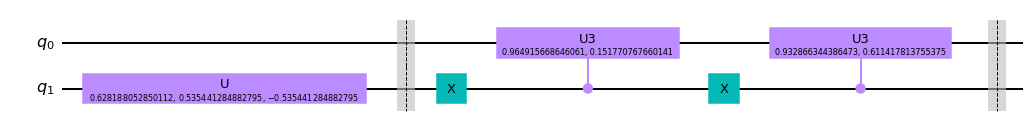

In [5]:
backend = Aer.get_backend('qasm_simulator')
seed = 132     #set random seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed, shots=20000)
q = 2

parameters = ParameterVector('θ', 2**(q+1)-2)
param_dict = {parameter: np.random.random() for parameter in parameters}

parameter=[np.random.random() for i in range(2**(q+1)-2)]

State = PrepareState_Gen(parameters,q)
State = State.assign_parameters(parameters = param_dict)
State.draw(output='mpl')

# VQE qiskit code

# ZZ = PauliOp(Pauli(label='ZZ'))
# XI = PauliOp(Pauli(label='XI'))
# IX = PauliOp(Pauli(label='IX'))
# op = ZZ+0.5*(XI+IX) 

# optimizer = COBYLA(maxiter=1000)
# vqe = VQE(State,optimizer=optimizer,quantum_instance=quantum_instance)
# result = vqe.compute_minimum_eigenvalue(op)
# print(result.optimal_value)

In [2]:
def Ising_Hamilton(q,h):
    Ising_Hamilton = 0
    for i in range(q):
        Zterm  = 1
        Xterm  = 1
        for j in range(q-1):
            if j == i:
                Zterm = Zterm^Z^Z
                Xterm  = Xterm^X^I
            elif i == (q-1) and j == (i-1):
                Xterm = Xterm^I^X
                Zterm = 0
            else:
                Zterm = Zterm^I
                Xterm = Xterm^I
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    return Ising_Hamilton

In [7]:
def vqe_exact(qc, parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_Exact("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_Exact("Z",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        if file == None:
            continue
        else:
            file.write(f'Parameter: {parameter} \n ')
            file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton 

In [8]:
def vqe_exact1(qc, parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_Exact("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_Exact("Z",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        # file.write(f'Parameter: {parameter} \n ')
        # file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

In [9]:
def vqe_backend(qc,parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_backend("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_backend("Z",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        if file == None:
            continue
        else:
            file.write(f'Parameter: {parameter} \n ')
            file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

In [10]:
def vqe_backend_opt(parameter,qc,q,h,meas_map = None,file=None,shots=20000,realbackend = provider.get_backend('ibmq_qasm_simulator')):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # qc = TwoLocal(q, ['ry','rz'], 'cz', 'linear', reps=1)
    qc = qc.assign_parameters(parameter)

    # backend = Aer.get_backend('qasm_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    backend = realbackend
    
    def Qcir(gate=None,p=None,q = q,qc = qc):
        if gate == 'Z':
            cir = QuantumCircuit(q,2)
            cir.append(qc,[i for i in range(q)])
            cir.measure([p,p+1], [0,1])
        elif gate == 'X':
            cir = QuantumCircuit(q,1)
            cir.append(qc,[i for i in range(q)])
            cir.h(p)
            cir.measure(p,0)
        cir = transpile(cir, backend=backend,optimization_level=3)
        return cir

    def Check(result,index,shots = shots):
        if index not in result:
            result[index]=0
        return result[index]/shots
        
    Z_cir = [0 for i in range(q-1)]
    X_cir = [0 for i in range(q)]
    for i in range(q):
        X_cir[i] = Qcir('X',i)
        if i < (q-1):
            Z_cir[i] = Qcir('Z',i)
    Hamil_cir = []
    Hamil_cir = Z_cir+X_cir
    
    Assem = assemble(Hamil_cir, backend,meas_map=meas_map,shots=shots)
    job = backend.run(Assem)    
    result = job.result().get_counts()

    Ising_Hamilton = 0
    for i in range(q):
        Xterm = 2*Check(result[q+i-1],'0')-1
        if i < (q-1):
            Zterm = 4*(Check(result[i],'00'))-1-(2*(Check(result[i],'00')+Check(result[i],'01'))-1)-(2*(Check(result[i],'00')+Check(result[i],'10'))-1)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    # File write
    if file != None:
        file.write(f'\n Job ID: {job.job_id()} \n ')
        file.write(f'Parameter: {parameter} \n ')
        file.write(f'Result: {result} \n ')
        file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

In [11]:
def vqe_exact_opt(parameter,q,h,file=None,realbackend = Aer.get_backend('statevector_simulator')):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)   
    qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)

    # backend = Aer.get_backend('statevector_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    backend = realbackend

    def Res(result,p,gate):
        value = 0
        if gate == 'X':
            for index in result:
                if index[::-1][p:(p+1)] == '0':
                    value += result[index]
        elif gate == 'Z':
            for index in result:
                if index[::-1][p:(p+2)] == '00' or index[::-1][p:(p+2)] == '11':
                    value += result[index]
        return (2*value -1)
        
        
    Z_cir =  QuantumCircuit(q)
    Z_cir.append(qc,[i for i in range(q)])
    X_cir =  QuantumCircuit(q)
    X_cir.append(qc,[i for i in range(q)])
    X_cir.h([i for i in range(q)])
    Hamil_cir = [Z_cir,X_cir]
    
    job = execute(Hamil_cir, backend) 
    result = job.result().get_counts()

    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Res(result[1],i,'X')
        if i < (q-1):
            Zterm = Res(result[0],i,'Z')
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    # File write
    if file != None:
        file.write(f'\n Job ID: {job.job_id()} \n ')
        file.write(f'Parameter: {parameter} \n ')
        file.write(f'Result: {result} \n ')
        file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

**PSR method optimization for backend real device running**

In [51]:
q = 2
h = 0
tol = 1e-3
l_rate = 0.3
numberofiteration = 50
shots = 20000
backend = Aer.get_backend('qasm_simulator')
meas_map = None

qc = RealAmplitudes(q, entanglement='linear', reps=1)
parameters = [np.random.uniform(0,2*np.pi) for i in range(qc.num_parameters)]
# parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(2**(q+1)-2)]

def Qcir(gate=None,p=None,q = q,qc = qc):
    if gate == 'Z':
        cir = QuantumCircuit(q,2)
        cir.append(qc,[i for i in range(q)])
        cir.measure([p,p+1], [0,1])
    elif gate == 'X':
        cir = QuantumCircuit(q,1)
        cir.append(qc,[i for i in range(q)])
        cir.h(p)
        cir.measure(p,0)
    cir = transpile(cir, backend=backend,optimization_level=3)
    return cir

def Check(result,index,shots = shots):
    if index not in result:
        result[index]=0
    return result[index]/shots
    
for j in range(numberofiteration):
    Dvqe = [0 for i in range(len(parameters))]
    Hamil_cir = []
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = np.pi/2
        nqc = []
        nqc.append(qc.assign_parameters([parameters[i] + PSR_parameter[i] for i in range(len(parameters))]))
        nqc.append(qc.assign_parameters([parameters[i] - PSR_parameter[i] for i in range(len(parameters))]))
        for k in range(2):
            Z_cir = [0 for i in range(q-1)]
            X_cir = [0 for i in range(q)]
            for i in range(q):
                X_cir[i] = Qcir('X',i,q,nqc[k])
                if i < (q-1):
                    Z_cir[i] = Qcir('Z',i,q,nqc[k])
            Hamil_cir += Z_cir+X_cir
    job = execute(Hamil_cir, backend,meas_map=meas_map,shots=shots) 
    result = job.result().get_counts()
    for i in range(len(parameters)):
        Ising_Hamilton = [0,0]
        for n in range(2):
            for k in range(q):
                Xterm = 2*Check(result[i*(4*q-2)+n*(2*q-1)+q+k-1],'0')-1
                if k < (q-1):
                    Zterm = 4*(Check(result[i*(4*q-2)+n*(2*q-1)+k],'00'))-1-(2*(Check(result[i*(4*q-2)+n*(2*q-1)+k],'00')+Check(result[i*(4*q-2)+n*(2*q-1)+k],'01'))-1)-(2*(Check(result[i*(4*q-2)+n*(2*q-1)+k],'00')+Check(result[i*(4*q-2)+n*(2*q-1)+k],'10'))-1)
                elif k == (q-1):
                    Zterm = 0
                Ising_Hamilton[n] = Ising_Hamilton[n] + Zterm + h*Xterm
        Dvqe[i] = 1/2*(Ising_Hamilton[0]-Ising_Hamilton[1])
        parameters[i]-=l_rate*Dvqe[i]
print(vqe_exact1(parameters,q,h))

-0.9999947247680966


**PSR method optimization for backend exact simulator running**

In [50]:
q = 2
h = 0
tol = 1e-3
l_rate = 0.3
numberofiteration = 50
shots = 20000
backend = Aer.get_backend('statevector_simulator')
meas_map = None

qc = RealAmplitudes(q, entanglement='linear', reps=1)
parameters = [np.random.uniform(0,2*np.pi) for i in range(qc.num_parameters)]
# parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(2**(q+1)-2)]

def Res(result,p,gate):
    value = 0
    if gate == 'X':
        for index in result:
            if index[::-1][p:(p+1)] == '0':
                value += result[index]
    elif gate == 'Z':
        for index in result:
            if index[::-1][p:(p+2)] == '00' or index[::-1][p:(p+2)] == '11':
                value += result[index]
    return (2*value -1)
    
for j in range(numberofiteration):
    Dvqe = [0 for i in range(len(parameters))]
    Hamil_cir = []
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = np.pi/2
        nqc = []
        nqc.append(qc.assign_parameters([parameters[i] + PSR_parameter[i] for i in range(len(parameters))]))
        nqc.append(qc.assign_parameters([parameters[i] - PSR_parameter[i] for i in range(len(parameters))]))
        for k in range(2):
            Z_cir =  QuantumCircuit(q)
            Z_cir.append(nqc[k],[i for i in range(q)])
            X_cir =  QuantumCircuit(q)
            X_cir.append(nqc[k],[i for i in range(q)])
            X_cir.h([i for i in range(q)])
            Hamil_cir.append(Z_cir)
            Hamil_cir.append(X_cir)
    
    job = execute(Hamil_cir, backend,meas_map=meas_map) 
    result = job.result().get_counts()
    
    for i in range(len(parameters)):
        Ising_Hamilton = [0,0]
        for n in range(2):
            for k in range(q):
                Xterm = Res(result[4*i+2*n+1],k,'X')
                if k < (q-1):
                    Zterm = Res(result[4*i+2*n],k,'Z')
                elif k == (q-1):
                    Zterm = 0
                Ising_Hamilton[n] = Ising_Hamilton[n] + Zterm + h*Xterm
        Dvqe[i] = 1/2*(Ising_Hamilton[0]-Ising_Hamilton[1])
        parameters[i]-=l_rate*Dvqe[i]
print(vqe_exact1(parameters,q,h))

-1.0


**Classical check**

In [99]:
q = 2
h = 0.001
# Haminlton matrix
Hal =  Operator(Ising_Hamilton(q,h))
# Classical solver
w,v = np.linalg.eig(Hal)
# print("Eigenvectors")
# print(v)
# print("Eigenvalues")
# print(w)
minimum=w[0]
min_spot=0
for i in range(1,2**q):
    if w[i]<minimum:
        min_spot=i
        minimum=w[i]                   
groundstate = v[:,min_spot]
# print("Ground State")
print(v[3].dot(Operator(X^X).dot(v[3])))
print(w)
print(v)
print(v[3][1]**2+v[3][2]**2+v[3][0]**2+v[3][3]**2)
# print("Ground Energy")
# print(minimum)

# Check Expectation function
# qc = QuantumCircuit(3)
# qc.initialize(groundstate,[0,1,2])
# vZZI = Expectation_Exact("Z",1,2,circ = qc)[0]
# vZIZ = Expectation_Exact("Z",0,2,circ = qc)[0]
# vXII = Expectation_Exact("X",2,circ = qc)[0]
# vIXI = Expectation_Exact("X",1,circ = qc)[0]
# vIIX = Expectation_Exact("X",0,circ = qc)[0]
# print(vZIZ+vZZI+0.5*(vXII+vIIX+vIXI))


(-0.9999995000707641+0j)
[-1.000002+0.j  1.      +0.j  1.000002+0.j -1.      +0.j]
[[-7.07105721e-04-0.j  7.07106781e-01+0.j  7.07106428e-01+0.j
  -3.93441479e-14-0.j]
 [ 7.07106428e-01+0.j  7.32011326e-14+0.j  7.07105721e-04+0.j
   7.07106781e-01+0.j]
 [ 7.07106428e-01-0.j  7.34232314e-14+0.j  7.07105721e-04+0.j
  -7.07106781e-01-0.j]
 [-7.07105721e-04-0.j -7.07106781e-01+0.j  7.07106428e-01+0.j
  -3.91222117e-14-0.j]]
(1.000000000069389+0j)


**Real backend running**

In [126]:
q = 16
tol = 1e-3
shots = 20000
real = TwoLocal(q, ['ry','rz'], 'cz', 'linear', reps=1)
optimizer = COBYLA(maxiter=1000)
# parameters = ParameterVector('θ', 2**(q+1)-2)
# State = PrepareState_Gen(parameters,q)

# cvalue = []
meas_map = None
# qvalue = []
# isvalue = []
# hvalue = []
# geisvalue = []
# newhvalue = []
# bvalue = []
b0value = []
# lvalue = []
# mvalue = []

# b = open("2quibitIsing_RealDevice_ibmq_belem_01.txt", "a")
# b.write('\n ibmq_belem \n ')
# backb = provider.get_backend('ibmq_belem')
b0 = open("16quibitIsing_ibmq_qasm_simulator_TwoLo_Cobyla.txt", "a")
b0.write('\n ibmq_qasm_simulator \n ')
backb0 = provider.get_backend('ibmq_qasm_simulator')
# l = open("3quibitIsing_RealDevice_ibmq_belem_134.txt", "a")
# l.write('\n ibmq_belem \n ')
# backl = provider.get_backend('ibmq_belem')
# m = open("3quibitIsing_RealDevice_ibmq_lima_012.txt", "a")
# m.write('\n ibmq_lima \n ')
# backm = provider.get_backend('ibmq_lima')

for i in [2]:
    h=i
    # hvalue.append(h)
    b0.write(f'\n h: {h}\n')
    # op = Ising_Hamilton(q,h) 

    # Classical solver
    # w,v = np.linalg.eig(Operator(op))
    # minimum=w[0]
    # min_spot=0
    # for i in range(1,2**q):
    #     if w[i]<minimum:
    #         min_spot=i
    #         minimum=w[i]                   
    # groundstate = v[:,min_spot]
    # cvalue.append(minimum)

    # VQE Qiskit solver
    # vqeqiskit = VQE(State,optimizer=optimizer,quantum_instance=quantum_instance)
    # result = vqeqiskit.compute_minimum_eigenvalue(op)
    # qvalue.append(result.optimal_value)
    
    # Ising VQE solver
    # parameter = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(real.num_parameters)]
    # re = minimize(vqe_backend_opt,parameter,args=(q, h,meas_map,b,20000,backb),method="COBYLA",tol=tol)
    # bvalue.append(re.fun)

    parameter = [ 3.37903733,  2.13921968 , 6.14481476 ,-0.04061991  ,1.31294594 , 3.36949252,
  6.26102546 , 2.84591345 , 5.23171484,-0.124101 ,   4.00608692,  3.41296542,
  0.72957587 , 6.05714761 , 5.35819542,  3.56145944 , 2.9164785 ,  3.78606804,
  4.51021358,  5.21900314 , 0.55869198 , 5.65338781 , 3.9287034 ,  5.02260065,
  3.23825728,  2.60276453 ,-0.28007675 , 1.77265769,  5.88392538,  4.95879866,
  6.64191516 , 2.40809548 , 1.90771368 ,-0.0765862 ,  5.15148357,  2.90072317,
  0.45121506,  8.03646744,  4.03641702 , 2.20995755 , 3.12533713,  4.9401355,
  4.96334434, -0.66182114,  2.96620264 , 0.33753222 , 3.21512208 , 4.76842201,
 -0.46141345,  2.34760209 , 0.08270568 , 3.89874704 ,-0.87907289,  6.03588731,
  6.19531225,  0.90717012,  3.20536306 , 5.97102262 , 3.11843101,  3.93043937,
  3.34415153 , 0.54654046,  0.51987676,  3.58285312] 
    re = minimize(vqe_backend_opt,parameter,args=(q, h,meas_map,b0,shots,backb0),method="COBYLA",tol=tol)
    b0value.append(re.fun)

    # parameter = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(real.num_parameters)]
    # re = minimize(vqe_backend_opt,parameter,args=(q, h,meas_map,l,20000,backl),method="COBYLA",tol=tol)
    # lvalue.append(re.fun)

    # parameter = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(real.num_parameters)]
    # re = minimize(vqe_backend_opt,parameter,args=(q, h,meas_map,m,20000,backm),method="COBYLA",tol=tol)
    # mvalue.append(re.fun)4

    b0.write(f'\n {h} : {re.fun} \n {re}')
b0.close()

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\qiskit\providers\ibmq\ibmqbackend.py:810: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  return super().run(circuits, job_name=job_name, job_share_level=job_share_level,


*Read file*

In [68]:
def Extr_data(f,mean_value,h_value,counts,values):
    i = 0
    for line in f:
        if 'Ising Hamilton' in line:
            i +=1
            counts.append(i)
            values.append(float(line[24:]))
        elif 'fun:' in line:
            mean_value.append(float(line[11:]))
            i = 0
        elif 'h:' in line:
            h_value.append(float(line[4:]))    
    return mean_value

In [73]:
mean_value1 =[]
h_value1 = []
counts1 = []
values1 = []
f = open("16quibitIsing_ibmq_qasm_simulator_TwoLo_Cobyla.txt", "rt")
Extr_data(f,mean_value1,h_value1,counts1,values1)
f.close()

**Running the comparison**

In [12]:
q = 6

cvalue = []
hvalue = []


for i in range(10):
    h = 2*i/10
    hvalue.append(h)
    op = Ising_Hamilton(q,h) 

    # Classical solver
    w,v = np.linalg.eig(Operator(op))
    minimum=w[0]
    min_spot=0
    for i in range(1,2**q):
        if w[i]<minimum:
            min_spot=i
            minimum=w[i]                   
    groundstate = v[:,min_spot]
    cvalue.append(minimum)

In [12]:
twovalue1 = []

# effvalue = []
# isvalue = []
realvalue = []
# psr = []
newhvalue = []

tol = 1e-4
l_rate = 0.3
numberofiteration = 50
optimizer = COBYLA(maxiter=1000)

itetwo1 = []
ite_valuetwo1 = []
itereal1 = []
ite_valuereal1 = []

counts = []
values = []
params = []
deviation = []
def callback(eval_count, parameters, mean, std):  
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

In [31]:
for i in [0.9]:
    h = i
    newhvalue.append(h)
    op = Ising_Hamilton(q,h) 

    # twol = TwoLocal(q, ['ry','rz'], 'cz', 'linear', reps=1, insert_barriers=True)
    # real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
    parameter = ParameterVector('θ', 2**(q+1)-2)
    two = PrepareState_Gen(parameter,q)
    # eff = EfficientSU2(q, reps=1, entanglement='linear', insert_barriers=True)

    parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(two.num_parameters)]
    
    # VQE qiskit solver, Two Local ansatz
    # vqer = VQE(two,optimizer=optimizer,quantum_instance=quantum_instance)
    # result = vqer.compute_minimum_eigenvalue(op)
    # twovalue.append(result.optimal_value)

    # VQE qiskit solver, EfficientSU2 ansatz
    # vqer = VQE(eff,optimizer=optimizer,quantum_instance=quantum_instance)
    # result = vqer.compute_minimum_eigenvalue(op)
    # effvalue.append(result.optimal_value)

    # VQE qiskit solver, RealAmplitude ansatz
    vqer = VQE(two,optimizer=optimizer,quantum_instance=quantum_instance, initial_point=parameters,callback=callback)
    result = vqer.compute_minimum_eigenvalue(op)
    realvalue.append(result.optimal_value)

    # VQE qiskit solver, Two Local (linear eng map) ansatz
    # vqer = VQE(two,optimizer=optimizer,quantum_instance=quantum_instance)
    # result = vqer.compute_minimum_eigenvalue(op)
    # isvalue.append(result.optimal_value)
    
    # Parameter-shift rules two
    for j in range(numberofiteration):
        itetwo1.append(j)
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = []
        fix_parameters.append(parameters)
        for i in range(len(parameters)):
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[i] = np.pi/2
            Dvqe[i] = (1/2*(vqe_exact([fix_parameters[0][i] + PSR_parameter[i] for i in range(len(fix_parameters[0]))],q,h)-vqe_exact([fix_parameters[0][i] - PSR_parameter[i] for i in range(len(fix_parameters[0]))],q,h)))
            parameters[i]-=l_rate*Dvqe[i]
        ite_valuetwo1.append(vqe_exact(parameters,q,h))
    twovalue1.append(vqe_exact(parameters,q,h))

    # parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(real.num_parameters)]
    #     # Parameter-shift rules real
    # for j in range(numberofiteration):
    #     itereal1.append(j)
    #     Dvqe = [0 for i in range(len(parameters))]
    #     fix_parameters = []
    #     fix_parameters.append(parameters)
    #     for i in range(len(parameters)):
    #         PSR_parameter = [0 for i in range(len(parameters))]
    #         PSR_parameter[i] = np.pi/2
    #         Dvqe[i] = (1/2*(vqereal([fix_parameters[0][i] + PSR_parameter[i] for i in range(len(fix_parameters[0]))],q,h)-vqereal([fix_parameters[0][i] - PSR_parameter[i] for i in range(len(fix_parameters[0]))],q,h)))
    #         parameters[i]-=l_rate*Dvqe[i]
    #     ite_valuereal1.append(vqereal(parameters,q,h))
    # realvalue1.append(vqereal(parameters,q,h))

In [14]:
psr = []
l_rate = 0.3
numberofiteration = 50
for i in range(2,12):
    q = i
    real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
    parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(real.num_parameters)]
    for j in range(numberofiteration):
        Dvqe = [i for i in range(len(parameters))]
        fix_parameters = []
        fix_parameters.append(parameters)
        for i in range(len(parameters)):
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[i] = np.pi/2

            Dvqe[i] = (1/2*(vqe_exact([fix_parameters[0][i] + PSR_parameter[i] for i in range(len(fix_parameters[0]))],q,h)-vqe_exact([fix_parameters[0][i] - PSR_parameter[i] for i in range(len(fix_parameters[0]))],q,h)))
            parameters[i]-=l_rate*Dvqe[i]
    psr.append(vqe_exact(parameters,q,h))

In [14]:
isvalue = []
tol = 1e-3
real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
for i in range(5):
    h=4*i/10
    # VQE solver, RealAmplitude ansatz
    parameter = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(real.num_parameters)]
    re = minimize(vqe_exact,parameter,args=(q, h),method="COBYLA",tol=tol)
    isvalue.append(re.fun)

In [20]:
q = 3
h = 0
optimizer = COBYLA(maxiter=1000)
tol = 1e-4
op = Ising_Hamilton(q,h) 
real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(real.num_parameters)]

vqer = VQE(real,optimizer=optimizer,quantum_instance=quantum_instance,initial_point=parameters)
result = vqer.compute_minimum_eigenvalue(op)
# re = minimize(vqe,parameter,args=(q, h),method="COBYLA",tol=tol)

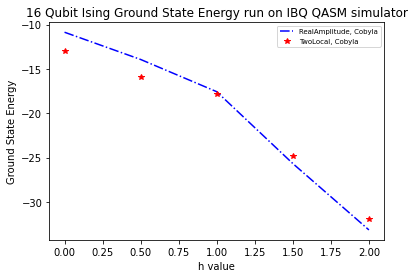

In [83]:
# plt.plot(hvalue, np.real(cvalue), 'r-',label='Classical diagonal method')
# plt.plot(newhvalue, twovalue, 'ro', label='TwoLocal, Cobyla, full entanglement')
# plt.plot(newhvalue, effvalue, 'b*', label='EfficientSU2, Cobyla)')
# plt.plot(newhvalue, isvalue, 'r--',label=' TwoLocal, Cobyla, linear entanglement')

# plt.plot(newhvalue, realvalue, 'g*',label='General Ansatz, Cobyla')
# plt.plot(newhvalue, twovalue1, 'b^',label='General Ansatz, PSR (lrate: 0.3, ite: 50)')
# plt.plot(newhvalue, realvalue0, 'y^',label='RealAmplitude, full entanglement')
# plt.plot(newhvalue, realvalue1, 'c--',label='RealAmplitude, linear entanglement')
plt.plot(h_value0, mean_value0, 'b-.',label='RealAmplitude, Cobyla')
plt.plot(h_value1, mean_value1, 'r*',label='TwoLocal, Cobyla')


# plt.axhline(y=-2.13718764, color='blue', linestyle='-.',label = 'h = 0.3')
# plt.plot(counts[3823:4000], values[3823:4000], 'g--',label='General Ansatz, Cobyla')
# plt.plot(itetwo1[250:300], ite_valuetwo1[250:300], 'g-',label='General Ansatz, PSR (lrate: 0.3, ite: 50)')
# plt.axhline(y=-5.67739549, color='g', linestyle='-.',label = 'h = 1.8')
plt.legend(loc='best',fontsize='x-small')
# plt.title('Quantum deviation of 3 qubit Ising energy to classical solver (PSR)')
plt.title('16 Qubit Ising Ground State Energy run on IBQ QASM simulator')
plt.ylabel('Ground State Energy')
plt.xlabel('h value')
plt.show()

In [ ]:
# for backend in Aer.backends():
#     print(backend)
# backend = Aer.get_backend('?')

# qct = QuantumCircuit(2,2)
# qct.h(0)
# qct.cx(0,1)
# qct.barrier(range(2))
# qct.measure(range(2),range(2))

# tqc = transpile(qct, backend)
# qobj = assemble(tqc,shots=100)
# result = backend.run(qobj).result().get_counts(qct)
# print(result['00'])

#result = backend.run(qct).result().get_statevector(qct)

# probs = Statevector(qct).probabilities([0])
# print(probs[0]) 

# qct = Statevector(qct)
# qct.draw('qsphere')
# qct.draw('latex')
# qct.draw('hinton')

# qct = Operator(qct)
# qct.data

# ZZ = PauliOp(Pauli(label='ZZ'))
# XI = PauliOp(Pauli(label='XI'))
# IX = PauliOp(Pauli(label='IX'))
# op =SummedOp([(Z^Z),(0.5*X^I),(0.5*I^X)])
# op1 = (Z^Z)+0.5*((X^I)+(I^X))
# op2 = ZZ + 0.5*(XI+IX)

# exact_solver = NumPyMinimumEigensolver()
# exact_result = exact_solver.compute_minimum_eigenvalue(op1)

# qp=QuadraticProgram()
# qp.from_ising(op,linear=True) # op must contain only Z,I gates to convert to Quadratic Program
# exact = MinimumEigenOptimizer(exact_solver)
# exact_result = exact.solve(qp)


# backend = provider.get_backend('ibmq_santiago')
# noise_model = NoiseModel.from_backend(backend)
# transpile_qc = transpile(qc,backend,optimization_level=3)
# assemble_qc = assemble(transpile_qc,shots=2048)
# simulator = Aer.get_backend('qasm_simulator')
# result = simulator.run(assemble_qc,noise_model=noise_model,memory=True).result()
# statevector = result.get_memory()

**Parameter-shift rules**

In [22]:
def PSR_exact(q,h,qc,parameters, l_rate=0.2, ite = 100):
    Deriva = [[0] for i in range(qc[0].num_parameters)]
    Upd_para = [[0] for i in range(qc[0].num_parameters)]
    vqe = []
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]

        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]

        for i in range(len(parameters)):
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[i] = np.pi/2

            if i % 2 == 0:
                Dvqe[i] = (1/2*(vqe_exact(qc[0], [fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0],[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            else:
                # For general ansatz
                if qc[1] == 'gen':
                    Dvqe[i] = (1/sqrt(2)*(vqe_exact(qc[0], [fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0], [fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
                # For Pauli rotation gate ansatz
                else:
                    Dvqe[i] = (1/2*(vqe_exact(qc[0], [fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0], [fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            
            parameters[i]-=l_rate*Dvqe[i]
            
            Upd_para[i].append(parameter[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_exact(qc[0], parameters,q,h))
    return vqe_exact(qc[0], parameters,q,h), Deriva, Upd_para, vqe

In [15]:
# PSR for RealAmplitude
q = 2
h = 0
l_rate = 0.2
numberofiteration = 50
# parameter = ParameterVector('θ', 2**(q+1)-2)
# real = PrepareState_Gen(parameter,q)
real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)

itera1 = []
value1 = []
for y in range(10):
    h = 2*y/10
    itera1.append(h)
    # parameters = [np.random.uniform(0,2*np.pi) for i in range(real.num_parameters)]
    parameters = [0.5 for i in range(real.num_parameters)]
    for j in range(numberofiteration):
        # itera1.append(j)
        Dvqe = [0.5 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[i] = np.pi/2
            Dvqe[i] = (1/2*(vqe_exact(real,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(real,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            parameters[i]-=l_rate*Dvqe[i]
    value1.append(vqe_exact(real,parameters,q,h))
    print(vqe_exact(real,parameters,q,h))
# print(PSR_simbackend(q,h,[real,'real'],parameters, l_rate=0.2, ite = 50)[0])

-1.0000000000000002


In [24]:
# PSR for Gen Ansatz
q = 2
h = 0
tol = 1e-3
l_rate = 0.2
numberofiteration = 100
parameter = ParameterVector('θ', 2**(q+1)-2)
real = PrepareState_Gen(parameter,q)

itera1 = []
value1 = []
parameters =  [0.5 for i in range(real.num_parameters)]
for j in range(numberofiteration):
    itera1.append(j)
    Dvqe = [0 for i in range(len(parameters))]
    fix_parameters = [0 for i in range(len(parameters))]
    for i in range(len(parameters)):
        fix_parameters[i] = parameters[i]
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = np.pi/2
        if i % 2 == 0:
            Dvqe[i] = (1/2*(vqe_exact(real,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(real,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        else:
            Dvqe[i] = (1/sqrt(2)*(vqe_exact(real,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(real,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        parameters[i]-=l_rate*Dvqe[i]
    value1.append(vqe_exact(real,parameters,q,h))
print(vqe_exact(real,parameters,q,h))
# print(PSR_exact(q,h,[real,'gen'],parameters, l_rate=0.2, ite = 100)[0])

-0.9997006027056132


In [14]:
# Coobyla method
q = 6
# h = 1
tol = 1e-3
optimizer = COBYLA(maxiter=1000)
# parameter = ParameterVector('θ', 2**(q+1)-2)
# real = PrepareState_Gen(parameter,q)
real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
op = Ising_Hamilton(q,h) 
counts = []
values = []
params = []
deviation = []
# def callback(eval_count, parameters, mean, std):  
#     counts.append(eval_count)
#     values.append(mean)
#     params.append(parameters)
#     deviation.append(std)
for i in range(10):
    h = 2*i/10
    op = Ising_Hamilton(q,h) 
    counts.append(h)
    parameters = [0.5 for i in range(real.num_parameters)]
    vqer = VQE(real,optimizer=optimizer,quantum_instance=quantum_instance,initial_point=parameters,callback=None)
    result = vqer.compute_minimum_eigenvalue(op)
    values.append(result.optimal_value)

In [144]:
# Finite Difference method
q = 3
h = 1
l_rate = 0.2
numberofiteration = 200
epsilon = 1e-3
# parameter = ParameterVector('θ', 2**(q+1)-2)
# real = PrepareState_Gen(parameter,q)
real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)

itera3 = []
value3 = []
# for y in range(10):
#     h = 2*y/10
parameters = [0 for i in range(real.num_parameters)]
#     itera3.append(h)
for j in range(numberofiteration):
    itera3.append(j)
    Dvqe = [pi/2 for i in range(len(parameters))]
    fix_parameters = [0 for i in range(len(parameters))]
    for i in range(len(parameters)):
        fix_parameters[i] = parameters[i]
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = epsilon
        
        Dvqe[i] = (1/(2*epsilon)*(vqe_exact1([fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact1([fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        
        parameters[i]-=l_rate*Dvqe[i]
    value3.append(vqe_exact1(parameters,q,h))
print(vqe_exact1(parameters,q,h))

-3.4769894757501323


In [16]:
for i in range(10):
    value0[i] -= np.real(cvalue[i])
    value1[i] -= np.real(cvalue[i])
    values[i] -= np.real(cvalue[i])

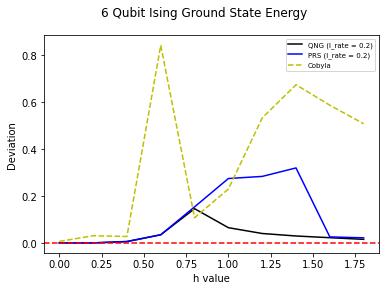

In [17]:
a = 0
b = 10
# plt.plot(itera0, value0, 'r-',label='l_rate = 0.3')
# plt.axhline(y=-1, color='r', linestyle='--')
# plt.plot(itera0[a:b], value0[a:b], 'c-*',label='PRS (l_rate = 0.2)')

# plt.figure()
# plt.subplot(211)
# plt.plot(itera02[a:b], value02[a:b], 'g-',label='QNG (l_rate = 0.7)')
# plt.plot(itera01[a:b], value01[a:b], 'c-*',label='QNG (l_rate = 0.5)')
# plt.plot(itera01[a:b], value01[a:b], 'c-',label='QNG (l_rate = 0.3)')
plt.plot(itera0[a:b], value0[a:b], color='Black',linestyle='-',label='QNG (l_rate = 0.2)')
plt.ylabel('Ground state energy')
# plt.axhline(y=-4.145560913317092, color='r', linestyle='--')
plt.legend(loc='best',fontsize='x-small')

# plt.subplot(212)
# plt.plot(itera3[a:b], value3[a:b], 'g-*',label='GD Newton (l_rate = 0.2)')
# plt.plot(itera2[a:b], value2[a:b], 'r-',label='QNG (l_rate = 0.05)')
plt.plot(itera1[a:b], value1[a:b], 'b-',label='PRS (l_rate = 0.2)')
plt.plot(counts[a:b], values[a:b], 'y--',label='Cobyla')
plt.axhline(y=0, color='r', linestyle='--')
# plt.plot(hvalue,np.real(cvalue),'r--')

# plt.axhline(y=-3.493959207434937, color='r', linestyle='--')
plt.legend(loc='best',fontsize='x-small')
plt.suptitle('6 Qubit Ising Ground State Energy ')
plt.ylabel('Deviation')
plt.xlabel('h value')
plt.show()

**Parameter-shift rules for general ansatz**

In [ ]:
q = 2
h = 1
tol = 1e-3
l_rate = 0.05
numberofiteration = 100
parameter = ParameterVector('θ', 2**(q+1)-2)
real = PrepareState_Gen(parameter,q)

ite = []
ite_value = []
parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(real.num_parameters)]
for j in range(numberofiteration):
    ite.append(j)
    Dvqe = [0 for i in range(len(parameters))]
    fix_parameters = [0 for i in range(len(parameters))]
    for i in range(len(parameters)):
        fix_parameters[i] = parameters[i]
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = np.pi/2
        if i % 2 == 0:
            Dvqe[i] = (1/2*(vqe_exact([fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact([fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        else:
            Dvqe[i] = (1/sqrt(2)*(vqe_exact([fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact([fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        parameters[i]-=l_rate*Dvqe[i]
    ite_value.append(vqe_exact(parameters,q,h))
psr.append(vqe_exact(parameters,q,h))

**Classical Gradient Descend (Numerical Derivative)**

In [ ]:
def FiniteDiff_exact(q,h,qc,parameters, epsilon = 1e-3 ,l_rate=0.2, ite = 100):
    Deriva = [[0] for i in range(qc[0].num_parameters)]
    Upd_para = [[0] for i in range(qc[0].num_parameters)]
    vqe = []
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            finite_diff = [0 for i in range(len(parameters))]
            finite_diff [i] = epsilon

            Dvqe[i] = (1/(2*epsilon)*(vqe_exact(qc[0], [fix_parameters[i] + finite_diff[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0],[fix_parameters[i] - finite_diff[i] for i in range(len(fix_parameters))],q,h)))
        
            parameters[i]-=l_rate*Dvqe[i]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_exact(qc[0], parameters,q,h))
    return vqe_exact(qc[0], parameters,q,h), Deriva, Upd_para, vqe

In [12]:
q = 4
h = 0
tol = 1e-3
l_rate = 0.2
numberofiteration = 100
epsilon = 1e-4

real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)

itera3 = []
value3 = []
parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(real.num_parameters)]
for j in range(numberofiteration):
    itera3.append(j)
    Dvqe = [0 for i in range(len(parameters))]
    fix_parameters = [0 for i in range(len(parameters))]
    for i in range(len(parameters)):
        fix_parameters[i] = parameters[i]
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = epsilon
        
        Dvqe[i] = (1/(2*epsilon)*(vqe_exact([fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact([fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        
        parameters[i]-=l_rate*Dvqe[i]
    value3.append(vqe_exact(parameters,q,h))
psr.append(vqe_exact(parameters,q,h))

ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

**Quantum Natural Gradient Descent (Block-diagonal Approximation)**

In [19]:
# QNG for RealAmplitude Ansatz
q = 3
h = 2
l_rate = 0.1
numberofiteration = 100

RealAmp = {'qubit': q , 'entanglement': 'linear','reps':1}
real = RealAmplitudes(RealAmp['qubit'], entanglement=RealAmp['entanglement'], reps=RealAmp['reps'])
num_para = real.num_parameters

itera0 = []
value0 = []

# Create sub-circuit
qc = [0 for i in range(int(num_para/q))]
for k in range(int(num_para/q)):
        qc[k] = RealAmplitudes(RealAmp['qubit'], entanglement=RealAmp['entanglement'], reps=k,skip_final_rotation_layer=True)

for y in range(10):
    h = 2*y/10
    itera0.append(h)
    parameters = [0 for i in range(num_para)]

    for l in range(numberofiteration):
        # itera0.append(l)
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]

        # Metric tensor
        g = np.zeros([num_para,num_para])
        sqc = [0 for i in range(int(num_para/q))]
        for m in range(num_para):
            k = m/q
            if k.is_integer():
                k = int(k)
                sqc[k] =  qc[k].assign_parameters(parameters[:q*k])
                for i in range(q):
                    for j in range(q):
                        if j == i: 
                            g[i+q*k,j+q*k] = 1 - Expectation_Exact('Y',j,circ=sqc[k])**2
                        else:
                            g[i+q*k,j+q*k]= Expectation_Exact('YY',i,j,circ= sqc[k])-Expectation_Exact('Y',i,circ= sqc[k])*Expectation_Exact('Y',j,circ = sqc[k])

        # Paramter-shift rules
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[m] = np.pi/2
            Dvqe[m] = (1/2*(vqe_exact1(real,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact1(real,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        
        # Pseudo-inverse
        g = linalg.pinv(g)
        # Update papramter
        for i in range(num_para):
            for j in range(num_para):
                parameters[i]-=l_rate*g[i,j]*Dvqe[j]
    value0.append(vqe_exact1(real,parameters,q,h))

In [ ]:
# QNG for SU2Efficient Ansatz
q = 2
# h = 1
l_rate = 0.2
numberofiteration = 200

su2Ans = {'qubit': q , 'entanglement': 'linear','reps':1 }
su2_ans = EfficientSU2(su2Ans['qubit'] ,entanglement=su2Ans['entanglement'], reps=su2Ans['reps'])
su2_num_para = su2_ans.num_parameters

itera0 = []
value0 = []

# Create sub-circuit for EfficientSU2 ansatz (perculiar for each type of ansatz)
qc = [0 for i in range(int(su2_num_para/q))]
for k in range(int(su2_num_para/(q))):
    if k % 2 ==0:              
        qc[k] = EfficientSU2(su2Ans['qubit'], entanglement=su2Ans['entanglement'], reps=int(k/2),skip_final_rotation_layer=True)
    else:
        qc[k] = EfficientSU2(su2Ans['qubit'], entanglement=su2Ans['entanglement'], reps=int((k-1)/2),skip_final_rotation_layer=False)

for y in range(10):
    h = 2*y/10
    parameters = [0.5 for i in range(su2_num_para)]
    itera0.append(h)
    for l in range(numberofiteration):
        # itera0.append(l)
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]

        # Metric tensor
        g = np.zeros([su2_num_para,su2_num_para])
        sqc = [0 for i in range(int(su2_num_para/q))]
        for m in range(su2_num_para):
            k = m/q
            if k.is_integer():
                k = int(k)
                # For Ry rotation gate
                if k % 2 == 0:
                    sqc[k] =  qc[k].assign_parameters(parameters[:q*k])
                    for i in range(q):
                        for j in range(q):
                            if j == i:
                                g[i+q*k,j+q*k] = 1 - Expectation_Exact('Y',j,circ=sqc[k])**2
                            else:
                                g[i+q*k,j+q*k]= Expectation_Exact('YY',i,j,circ= sqc[k])-Expectation_Exact('Y',i,circ= sqc[k])*Expectation_Exact('Y',j,circ = sqc[k])
                # For Rz rotation gate
                else:
                    sqc[k] =  qc[k].assign_parameters(parameters[:q*(k+1)])
                    for i in range(q):
                        for j in range(q):
                            if j == i:
                                g[i+q*k,j+q*k] = 1 - Expectation_Exact('1Z',j,circ=sqc[k])**2
                            else:
                                g[i+q*k,j+q*k]= Expectation_Exact('Z',i,j,circ= sqc[k])-Expectation_Exact('1Z',i,circ= sqc[k])*Expectation_Exact('1Z',j,circ = sqc[k])

        # Paramter-shift rules
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[m] = np.pi/2
            Dvqe[m] = (1/2*(vqe_exact1([fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact1([fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
        
        # Pseudo-inverse
        g = linalg.pinv(g)
        # Update papramter
        for i in range(su2_num_para):
            for j in range(su2_num_para):
                parameters[i]-=l_rate*g[i,j]*Dvqe[j]
    value0.append(vqe_exact1(parameters,q,h))

**Simultaneous perturbation stochastic approximation**

In [ ]:
def SPSA_exact(q,h,qc,parameters, epsilon = 0.15 ,l_rate=0.01, ite = 100):
    Deriva = [[0] for i in range(qc.num_parameters)]
    Upd_para = [[0] for i in range(qc.num_parameters)]
    vqe = []
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]
        per_vec = [np.random.choice([1,-1])*epsilon for i in range(len(parameters))]
        spsa_diff = vqe_backend(qc, np.add(parameters,per_vec),q,h)-vqe_backend(qc,np.subtract(parameters,per_vec),q,h)
        for i in range(len(parameters)):

            Dvqe[i] = 1/(2*per_vec[i])*spsa_diff
        
            parameters[i]-=l_rate*Dvqe[i]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_backend(qc, parameters,q,h))
    return vqe_exact(qc, parameters,q,h), Deriva, Upd_para, vqe

**Quantum Natural Simultaneous perturbation stochastic approximation**

In [ ]:
def QN_SPSA(qc,parameter,gk_1,Nth_iter,beta = 0.001 ,eps = 0.01):
    q = qc.num_qubits
    num_parameters = qc.num_parameters
    # Metric tensor
    g = np.zeros([num_parameters,num_parameters])
    # Perturbation vector
    per_vec1 = [np.random.choice([1,-1])*eps for i in range(len(parameter))]
    per_vec2 = [np.random.choice([1,-1])*eps for i in range(len(parameter))]
    # PQC
    qc1 = qc.assign_parameters(np.add(np.add(parameter,per_vec1),per_vec2))
    qc2 = qc.assign_parameters(np.add(parameter,per_vec1))
    qc3 = qc.assign_parameters(np.add(np.add(parameter,[-i for i in per_vec1]),per_vec2))
    qc4 = qc.assign_parameters(np.add(parameter,[-i for i in per_vec1]))
    qc =  qc.assign_parameters(parameter).inverse()
    # Construct expecation value
    qc1.append(qc,[_ for _ in range(q)])
    qc2.append(qc,[_ for _ in range(q)])
    qc3.append(qc,[_ for _ in range(q)])
    qc4.append(qc,[_ for _ in range(q)])
    # Execute the circuits
    backend = Aer.get_backend('statevector_simulator')
    job = execute([qc1,qc2,qc3,qc4], backend) 
    result = job.result().get_counts()
    # Get the |000..0> state index
    index = ''
    for i in range(q):
        index += '0'
    # Get the wanted results from running backend
    fun = [0]*4
    for i in range(4):
        for ind in result[i]:
            if ind == index:
                fun[i] = result[i][index]
    # Calculating the shifting value
    F = [fun[0],-fun[1],-fun[2],fun[3]]
    F = sum(F)
    # QN_SPSA matrix
    for i in range(q):
        for j in range(q):
            g[i][j]=-1/2*F/(2*eps**4)*(per_vec1[i]*per_vec2[j]+per_vec1[j]*per_vec2[i])/2
    # The smoothing of the QN_SPSA matrix
    g = Nth_iter/(Nth_iter+1)*gk_1+1/(Nth_iter+1)*g
    # Regularization to ensure invertibility (positive semi-definite)
    g = sqrtm(g.dot(g))+beta*np.identity(num_parameters)
    g = g.real
    return g

In [ ]:
def FiniteDiff_QN_SPSA(q,h,qc,parameters, epsilon = 1e-2 ,l_rate=0.01, ite = 100):
    Deriva = [[0] for i in range(qc.num_parameters)]
    Upd_para = [[0] for i in range(qc.num_parameters)]
    vqe = []
    g = np.zeros([len(parameters),len(parameters)])
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            finite_diff = [0 for i in range(len(parameters))]
            finite_diff [i] = epsilon

            Dvqe[i] = (1/(2*epsilon)*(vqe_backend(qc, [fix_parameters[i] + finite_diff[i] for i in range(len(fix_parameters))],q,h)-vqe_backend(qc,[fix_parameters[i] - finite_diff[i] for i in range(len(fix_parameters))],q,h)))
        
        # Get the QN_SPSA
        g = QN_SPSA(qc,parameters,g,Nth_iter=j)
        # Pseudo-inverse
        g_1 = linalg.pinv(g)
        # Update papramter
        for i in range(len(parameters)):
            for j in range(len(parameters)):
                parameters[i]-=l_rate*g_1[i,j]*Dvqe[j]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_backend(qc, parameters,q,h))
    return vqe_exact(qc, parameters,q,h), Deriva, Upd_para, vqe

In [ ]:
def SPSA_QN_SPSA(q,h,qc,parameters, epsilon = 0.01 ,l_rate=0.01, ite = 100):
    Deriva = [[0] for i in range(qc.num_parameters)]
    Upd_para = [[0] for i in range(qc.num_parameters)]
    vqe = []
    q = qc.num_qubits
    num_parameters = qc.num_parameters
    g = np.zeros([len(parameters),len(parameters)])
    gk_1 = np.zeros([len(parameters),len(parameters)])
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]
        # Perturbation vector
        per_vec = [np.random.choice([1,-1])*epsilon for i in range(len(parameters))]
        spsa_diff = vqe_backend(qc, np.add(parameters,per_vec),q,h)-vqe_backend(qc,np.subtract(parameters,per_vec),q,h)
        for i in range(len(parameters)):

            Dvqe[i] = 1/(2*per_vec[i])*spsa_diff
        
        # Get the QN_SPSA
        g = QN_SPSA(qc,parameters,g,Nth_iter=j)
        # Pseudo-inverse
        g_1 = linalg.pinv(g) 
        # Update papramter
        for i in range(len(parameters)):
            for j in range(len(parameters)):
                parameters[i]-=l_rate*g_1[i,j]*Dvqe[j]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_backend(qc, parameters,q,h))
    return vqe_exact(qc, parameters,q,h), Deriva, Upd_para, vqe